In [1]:
#!conda install intake fsspec intake-xarray intake-thredds -c conda-forge -y

In [2]:
#!conda install eccodes cfgrib -c conda-forge -y

In [3]:
#!pip install climetlab --quiet

In [4]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

# Calculate skill for NWP model GEFS for 6-hourly global forecasts

In [5]:
import intake
import fsspec  # caching downloads

# specify caching location, where to store files to with their original names
fsspec.config.conf["simplecache"] = {
    "cache_storage": "../my_caching_folder",
    "same_names": True,
}
import intake_xarray  # access files hosted via THREDDS
import climetlab  # download ERA5

import xarray as xr
import numpy as np

import climpred  # forecast verification

<IPython.core.display.Javascript object>

## Find the data

GEFS output can be found on a `THREDDS` server: https://www.ncei.noaa.gov/thredds/catalog/model-gefs-003/202008/20200831/catalog.html

Here, we use `intake-thredds` to access the THREDDS catalog, `intake-xarray` to access the files and cache them with `fsspec`. However, you can also download the files manually, e.g. with `wget`:

- https://intake.readthedocs.io/en/latest/
- https://intake-xarray.readthedocs.io/en/latest/
- https://intake-thredds.readthedocs.io/en/latest/
- https://filesystem-spec.readthedocs.io/en/latest/

In [6]:
# all the metadata about GEFS
cat = intake.open_thredds_cat(
    "https://www.ncei.noaa.gov/thredds/catalog/model-gefs-003/202008/20200831/catalog.html"
)
cat

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/siphon/catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-gefs-003/202008/20200831/catalog.html returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-gefs-003/202008/20200831/catalog.xml
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


No name found:
  args:
    url: https://www.ncei.noaa.gov/thredds/catalog/model-gefs-003/202008/20200831/catalog.html
  description: ''
  driver: intake_thredds.cat.ThreddsCatalog
  metadata:
    authority:
    - gov.noaa.ncdc
    contributor:
      Scientific Contact:
      - Zoltar Toth
      Technical Contact:
      - Yuejian Zhu
    creator:
    - {}
    dataType: GRID
    date:
    - type: created
      value: '2007-03-27'
    - type: issued
      value: '2007-10-01'
    documentation:
      abstract:
      - The Global Ensemble Forecast System (GEFS) is a weather forecast model made
        up of 21 separate forecasts, or ensemble members. The National Centers for
        Environmental Prediction (NCEP) started the GEFS to address the nature of
        uncertainty in weather observations, which are used to initialize weather
        forecast models. The proverbial butterfly flapping her wings can have a cascading
        effect leading to wind gusts thousands of miles away. This 

<IPython.core.display.Javascript object>

Opening without `backend_kwargs` raised `DatasetBuildError`. Need to specify variable by `filter_by_keys` for `grib` files.

DatasetBuildError: multiple values for unique key, try re-open the file with one of:

- filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
- filter_by_keys={'typeOfLevel': 'surface'}
- filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
- filter_by_keys={'typeOfLevel': 'heightAboveGround'}
- filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
- filter_by_keys={'typeOfLevel': 'atmosphere'}
- filter_by_keys={'typeOfLevel': 'nominalTop'}
- filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
- filter_by_keys={'typeOfLevel': 'meanSea'}

In [7]:
# how to open grib files: https://github.com/ecmwf/cfgrib/issues/170
intake_xarray.NetCDFSource(
    "simplecache::https://www.ncei.noaa.gov/thredds/fileServer/model-gefs-003/202008/20200831/gens-a_3_20200831_1800_000_20.grb2",
    xarray_kwargs=dict(
        engine="cfgrib",
        backend_kwargs=dict(
            filter_by_keys={"typeOfLevel": "heightAboveGround", "shortName": "2t"}
        ),
    ),
).to_dask().coords

Coordinates:
    number             int64 ...
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 90.0 89.0 88.0 ... -88.0 -89.0 -90.0
  * longitude          (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time         datetime64[ns] ...

<IPython.core.display.Javascript object>

## Get forecasts

In [8]:
inits_time = "0000"  # get forecasts started at 00:00
inits = ["20200829", "20200830", "20200831"]  # four initial dates
members = range(5)  # 5 members out of 20
leads = np.arange(0, 6 * 4 * 2 + 1, 6)  # 6h lead forecasts, 9 leads upto 48h

<IPython.core.display.Javascript object>

In [ ]:
for init in inits:
    for lead in leads:
        for member in members:
            try:
                url = f"https://www.ncei.noaa.gov/thredds/fileServer/model-gefs-003/202008/{init}/gens-a_3_{init}_{inits_time}_{str(lead).zfill(3)}_{str(member).zfill(2)}.grb2"
                # print(f'download init = {init}, lead = {lead}, member = {member}')
                intake_xarray.NetCDFSource(
                    f"simplecache::{url}",
                    xarray_kwargs=dict(
                        engine="cfgrib",
                        backend_kwargs=dict(
                            filter_by_keys={
                                "typeOfLevel": "heightAboveGround",
                                "cfVarName": "t2m",
                            }
                        ),
                    ),
                ).to_dask()
            except Exception as e:
                print("failed", type(e).__name__, e)

In [ ]:
init = xr.concat(
        [xr.concat(
            [xr.open_mfdataset(f'../my_caching_folder/gens-a_3_{init}_{inits_time}_{str(lead).zfill(3)}_*.grb2',
                               concat_dim='member', combine='nested',
                               engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'heightAboveGround', "cfVarName": "t2m"}))
             for lead in leads],
             dim='step') for init in inits],
        dim='time')

In [ ]:
# save time when reproducing
init = init.compute()
init.to_netcdf('tmp_GEFS_a.nc')

In [6]:
init = xr.open_dataset("tmp_GEFS_a.nc")

<IPython.core.display.Javascript object>

## Get observations

`climetlab` wraps `cdsapi` to download from the Copernicus Climate Data Store (CDS):

- https://cds.climate.copernicus.eu/cdsapp#!/home
- https://climetlab.readthedocs.io/en/latest/
- https://github.com/ecmwf/cdsapi/

In [9]:
obs = (
    climetlab.load_source(
        "cds",
        "reanalysis-era5-single-levels",
        product_type="reanalysis",
        time=["00:00", "06:00", "12:00", "18:00"],
        grid=[1.0, 1.0],
        param="2t",
        date=[
            "2020-08-29",
            "2020-08-30",
            "2020-08-31",
            "2020-09-01",
            "2020-09-02",
            "2020-09-03",
        ],
    )
    .to_xarray()
    .squeeze(drop=True)
).drop("valid_time")

<IPython.core.display.Javascript object>

In [10]:
# climetlab or cds enable logging.INFO
import logging

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

<IPython.core.display.Javascript object>

## Forecast skill verification with `climpred.HindcastEnsemble`

In [12]:
alignment = "same_inits"
hindcast = climpred.HindcastEnsemble(init.drop("valid_time")).add_observations(obs)

/Users/aaron.spring/Coding/climpred/climpred/checks.py:233: UserWarning: Did not find dimension "init", but renamed dimension time with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:233: UserWarning: Did not find dimension "lead", but renamed dimension step with CF-complying standard_name "forecast_period" to lead.
  warnings.warn(


<IPython.core.display.Javascript object>

In [13]:
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 3, latitude: 181, lead: 9, longitude: 360, member: 5)
Coordinates:
 number (member) int64 0 1 2 3 4
 * init (init) object 2020-08-29 00:00:00 ... 2020-08-31 00:00:00
 * lead (lead) float64 0.0 6.0 12.0 18.0 24.0 30.0 36.0 42.0 48.0
 heightAboveGround float64 2.0
 * latitude (latitude) float64 90.0 89.0 88.0 ... -88.0 -89.0 -90.0
 * longitude (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Dimensions without coordinates: member
Data variables:
 t2m (init, lead, member, latitude, longitude) float32 ...
Attributes:
 GRIB_edition: 2
 GRIB_centre: kwbc
 GRIB_centreDescription: US National Weather Service - NCEP 
 GRIB_subCentre: 2
 Conventions: CF-1.7
 institution: US National Weather Service - NCEP 
 history: 2021-04-14T21:14 GRIB to CDM+CF via cfgrib-0.9.9... Initialized Ensemble Dimensions: init : 3 latitude : 181 lead : 9 longitude : 360 member : 5 Coordinates: (6) number (member) int64 ... long_name : ensemble member numerical id units : 1 standard_name : realization array([0, 1, 2, 3, 4]) init (init) object 2020-08-29 00:00:00 ... 2020-08-... array([cftime.DatetimeProlepticGregorian(2020, 8, 29, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 30, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 31, 0, 0, 0, 0, has_year_zero=False)],
 dtype=object) lead (lead) float64 0.0 6.0 12.0 ... 36.0 42.0 48.0 units : hours array([ 0., 6., 12., 18., 24., 30., 36., 42., 48.]) heightAboveGround () float64 ... long_name : height above the surface units : m positive : up standard_name : height array(2.) latitude (latitude) float64 90.0 89.0 88.0 ... -89.0 -90.0 units : degrees_north standard_name : latitude long_name : latitude stored_direction : decreasing array([ 90., 89., 88., 87., 86., 85., 84., 83., 82., 81., 80., 79.,
 78., 77., 76., 75., 74., 73., 72., 71., 70., 69., 68., 67.,
 66., 65., 64., 63., 62., 61., 60., 59., 58., 57., 56., 55.,
 54., 53., 52., 51., 50., 49., 48., 47., 46., 45., 44., 43.,
 42., 41., 40., 39., 38., 37., 36., 35., 34., 33., 32., 31.,
 30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19.,
 18., 17., 16., 15., 14., 13., 12., 11., 10., 9., 8., 7.,
 6., 5., 4., 3., 2., 1., 0., -1., -2., -3., -4., -5.,
 -6., -7., -8., -9., -10., -11., -12., -13., -14., -15., -16., -17.,
 -18., -19., -20., -21., -22., -23., -24., -25., -26., -27., -28., -29.,
 -30., -31., -32., -33., -34., -35., -36., -37., -38., -39., -40., -41.,
 -42., -43., -44., -45., -46., -47., -48., -49., -50., -51., -52., -53.,
 -54., -55., -56., -57., -58., -59., -60., -61., -62., -63., -64., -65.,
 -66., -67., -68., -69., -70., -71., -72., -73., -74., -75., -76., -77.,
 -78., -79., -80., -81., -82., -83., -84., -85., -86., -87., -88., -89.,
 -90.]) longitude (longitude) float64 0.0 1.0 2.0 ... 357.0 358.0 359.0 units : degrees_east standard_name : longitude long_name : longitude array([ 0., 1., 2., ..., 357., 358., 359.]) Data variables: (1) t2m (init, lead, member, latitude, longitude) float32 ... GRIB_paramId : 167 GRIB_dataType : cf GRIB_numberOfPoints : 65160 GRIB_typeOfLevel : heightAboveGround GRIB_stepUnits : 1 GRIB_stepType : instant GRIB_gridType : regular_ll GRIB_NV : 0 GRIB_Nx : 360 GRIB_Ny : 181 GRIB_cfName : air_temperature GRIB_cfVarName : t2m GRIB_gridDefinitionDescription : Latitude/longitude. Also called equidistant cylindrical, or Plate Carree GRIB_iDirectionIncrementInDegrees : 1.0 GRIB_iScansNegatively : 0 GRIB_jDirectionIncrementInDegrees : 1.0 GRIB_jPointsAreConsecutive : 0 GRIB_jScansPositively : 0 GRIB_latitudeOfFirstGridPointInDegrees : 90.0 GRIB_latitudeOfLastGridPointInDegrees : -90.0 GRIB_longitudeOfFirstGridPointInDegrees : 0.0 GRIB_longitudeOfLastGridPointInDegrees : 359.0 GRIB_missingValue : 9999 GRIB_name : 2 metre temperature GRIB_shortName : 2t GRIB_totalNumber : 20 GRIB_units : K long_name : 2 metre temperature units : K standard_name : air_temperature [8796600 values with dtype=float32] Attributes: (7) GRIB_

<Observations>
Dimensions: (latitude: 181, longitude: 360, time: 24)
Coordinates:
 * time (time) object 2020-08-29 00:00:00 ... 2020-09-03 18:00:00
 * latitude (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
 * longitude (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Data variables:
 t2m (time, latitude, longitude) float32 dask.array<chunksize=(24, 181, 360), meta=np.ndarray>
Attributes:
 GRIB_edition: 1
 GRIB_centre: ecmf
 GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
 GRIB_subCentre: 0
 Conventions: CF-1.7
 institution: European Centre for Medium-Range Weather Forecasts
 history: 2021-06-25T22:59 GRIB to CDM+CF via cfgrib-0.9.9... Observations Dimensions: latitude : 181 longitude : 360 time : 24 Coordinates: (3) time (time) object 2020-08-29 00:00:00 ... 2020-09-... array([cftime.DatetimeProlepticGregorian(2020, 8, 29, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 29, 6, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 29, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 29, 18, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 30, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 30, 6, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 30, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 30, 18, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 31, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 31, 6, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 31, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 8, 31, 18, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 1, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 1, 6, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 1, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 1, 18, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 2, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 2, 6, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 2, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 2, 18, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 3, 0, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 3, 6, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 3, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeProlepticGregorian(2020, 9, 3, 18, 0, 0, 0, has_year_zero=False)],
 dtype=object) latitude (latitude) float64 90.0 89.0 88.0 ... -89.0 -90.0 units : degrees_north standard_name : latitude long_name : latitude stored_direction : decreasing array([ 90., 89., 88., 87., 86., 85., 84., 83., 82., 81., 80., 79.,
 78., 77., 76., 75., 74., 73., 72., 71., 70., 69., 68., 67.,
 66., 65., 64., 63., 62., 61., 60., 59., 58., 57., 56., 55.,
 54., 53., 52., 51., 50., 49., 48., 47., 46., 45., 44., 43.,
 42., 41., 40., 39., 38., 37., 36., 35., 34., 33., 32., 31.,
 30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19.,
 18., 17., 16., 15., 14., 13., 12., 11., 10., 9., 8., 7.,
 6., 5., 4., 3., 2., 1., 0., -1., -2., -3., -4., -5.,
 -6., -7., -8., -9., -10., -11., -12., -13., -14., -15., -16., -17.,
 -18., -19., -20., -21., -22., -23., -24., -25., -26., -27., -28., -29.,
 -30., -31., -32., -33., -34., -35., -36., -37., -38., -39., -40., -41.,
 -42., -43., -44., -45., -46., -47., -48., -49., -50., -51., -52., -53.,
 -54., -55., -56., -57., -58., -59., -60., -61., -62., -63., -64., -65.,
 -66., -67., -68., -69., -70., -71., -72., -73., -74., -75., -76., -77.,
 -78., -79., -80., -81., -82., -83., -84., -85., -86., -87., -88., -89.,
 -90.]) longitude (long

<IPython.core.display.Javascript object>

In [14]:
# still experimental, help appreciated https://github.com/pangeo-data/climpred/issues/605
# with climpred.set_options(seasonality='month'):
#     hindcast = hindcast.remove_bias(alignment=alignment, cross_validate=False, how='mean')

<IPython.core.display.Javascript object>

/Users/aaron.spring/Coding/climpred/climpred/classes.py:383: UserWarning: Error due to verification/control/uninitialized: xr.isel((), {'lead': range(1, 9)}) failed
ValueError: Dimensions {'lead'} do not exist. Expected one or more of Frozen(SortedKeysDict({'time': 24, 'latitude': 181, 'longitude': 360}))
  warnings.warn(


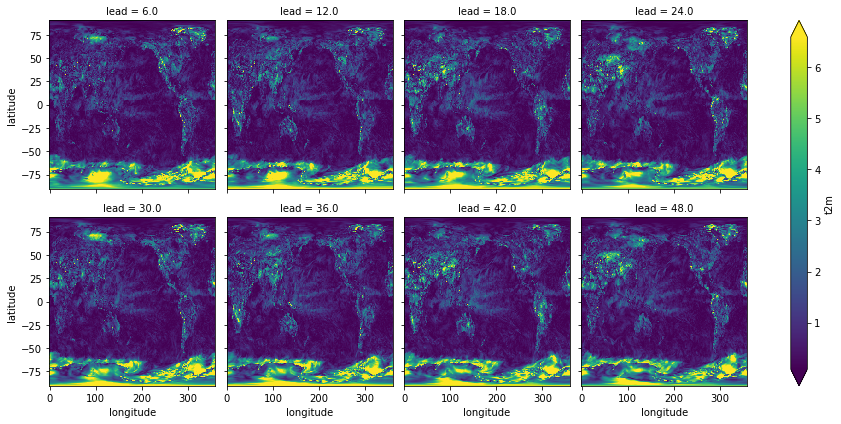

<IPython.core.display.Javascript object>

In [15]:
skill = hindcast.isel(lead=range(1, 9)).verify(
    metric="crps", comparison="m2o", alignment=alignment, dim=["init", "member"]
)

skill.t2m.plot(col="lead", col_wrap=4, robust=True)

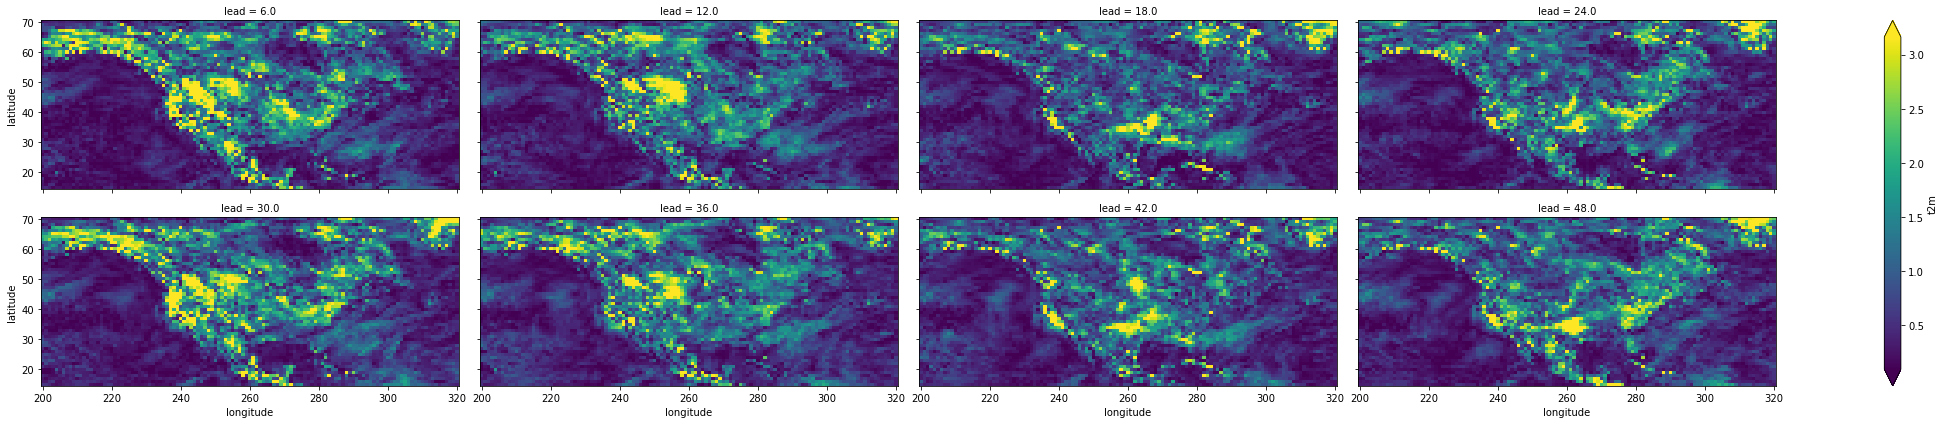

<IPython.core.display.Javascript object>

In [16]:
# zooming into north america
skill.sel(longitude=slice(200, 320), latitude=slice(70, 15)).t2m.plot(
    col="lead", col_wrap=4, robust=True, aspect=2.5
)